Downloaded from https://www.kaggle.com/code/prathameshgadekar/book-genre-prediction-nlp/notebook

<h1 style="font-family:verdana;"> <center>Welcome to 📚Book Prediction 📈EDA and Prediction using Various Models:</center> </h1>

# Table of Contents :
* [1. Introduction](#section1)
* [2. Importing Required Libraries](#section2)
* [3. Data Exploration](#section3)
  - [Feature Description](#section31)
  - [Null Value Distribution](#section32)
  - [Data Cleaning](#section33)
  - [Important Observations](#section34)
* [4. Exploratory Data Analysis (EDA)](#section4)
  - [Count Histogram for each Label](#section41)
  - [WordCloud Analysis](#section42)
* [Modelling](#section5)
  - [Data Pre-Processing](#section51)
  - [Modelling Using OneVsRestClassifer](#section52)
  - [Modelling Without Using OneVsRestClassifer](#section53)
  - [Accuracy and Time-Taken Plots](#section54)
  - [Final Observations](#section55)

<a id="section1"></a>
# Introduction :
![Books](https://www.shutterstock.com/image-photo/book-600w-732217162.jpg)
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">We are given a dataset about various books. We are given features such as their <code>Name</code>,<code>Genre</code>,<code>Summary</code>. This is a multi class classification problem. Our main goal here is to predict the <code>Genre</code> of the book based on its <code>Title</code> and <code>Summary</code>.</p>

<a id="section2"></a>
# Importing Required Libraries :

In [2]:
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')
clear_output()

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import missingno as msno #For missing value visualization

import plotly.offline as py
py.init_notebook_mode(connected=True)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import time

In [4]:
#For NLP
import re
import nltk
import string
# from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer

In [5]:
#For Calculation of Performance of Models
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score

In [6]:
#For Modelling Purpose
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB,BernoulliNB,MultinomialNB
from sklearn.dummy import DummyClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.multiclass import OneVsRestClassifier

In [7]:
nltk.download('omw-1.4')
clear_output()

<a id="section3"></a>
# Data Exploration :

<a id="section31"></a>
<div style="font-size:15px; font-family:verdana;"><h3 style="font-family:verdana;">Feature Description:</h3>

<ol>
    <li style="font-family:verdana;"><code style="font-family:verdana;">Index</code> - Index of every row.</li>
    <li style="font-family:verdana;"><code style="font-family:verdana;">Title</code> - Title of the Book .</li>
    <li style="font-family:verdana;"><code style="font-family:verdana;">Genre</code> - Genre of the Book.</li>
    <li style="font-family:verdana;"><code style="font-family:verdana;">Summary</code> - Synopsis of the Book.</li>
</ol>
</div>

In [86]:
data = pd.read_csv('../assets/data.csv')

data.head()

index                      title    genre  \
0      0          Drowned Wednesday  fantasy   
1      1              The Lost Hero  fantasy   
2      2  The Eyes of the Overworld  fantasy   
3      3            Magic's Promise  fantasy   
4      4             Taran Wanderer  fantasy   

                                             summary  
0   Drowned Wednesday is the first Trustee among ...  
1   As the book opens, Jason awakens on a school ...  
2   Cugel is easily persuaded by the merchant Fia...  
3   The book opens with Herald-Mage Vanyel return...  
4   Taran and Gurgi have returned to Caer Dallben...

In [9]:
data.shape

(4657, 4)

In [87]:
data.nunique()

index      4657
title      4296
genre        10
summary    4542
dtype: int64

<a id="section32"></a>
<div style="font-size:15px; font-family:verdana;"><h3 style="font-family:verdana;">Null Value Distribution:</h3>

<Axes: >

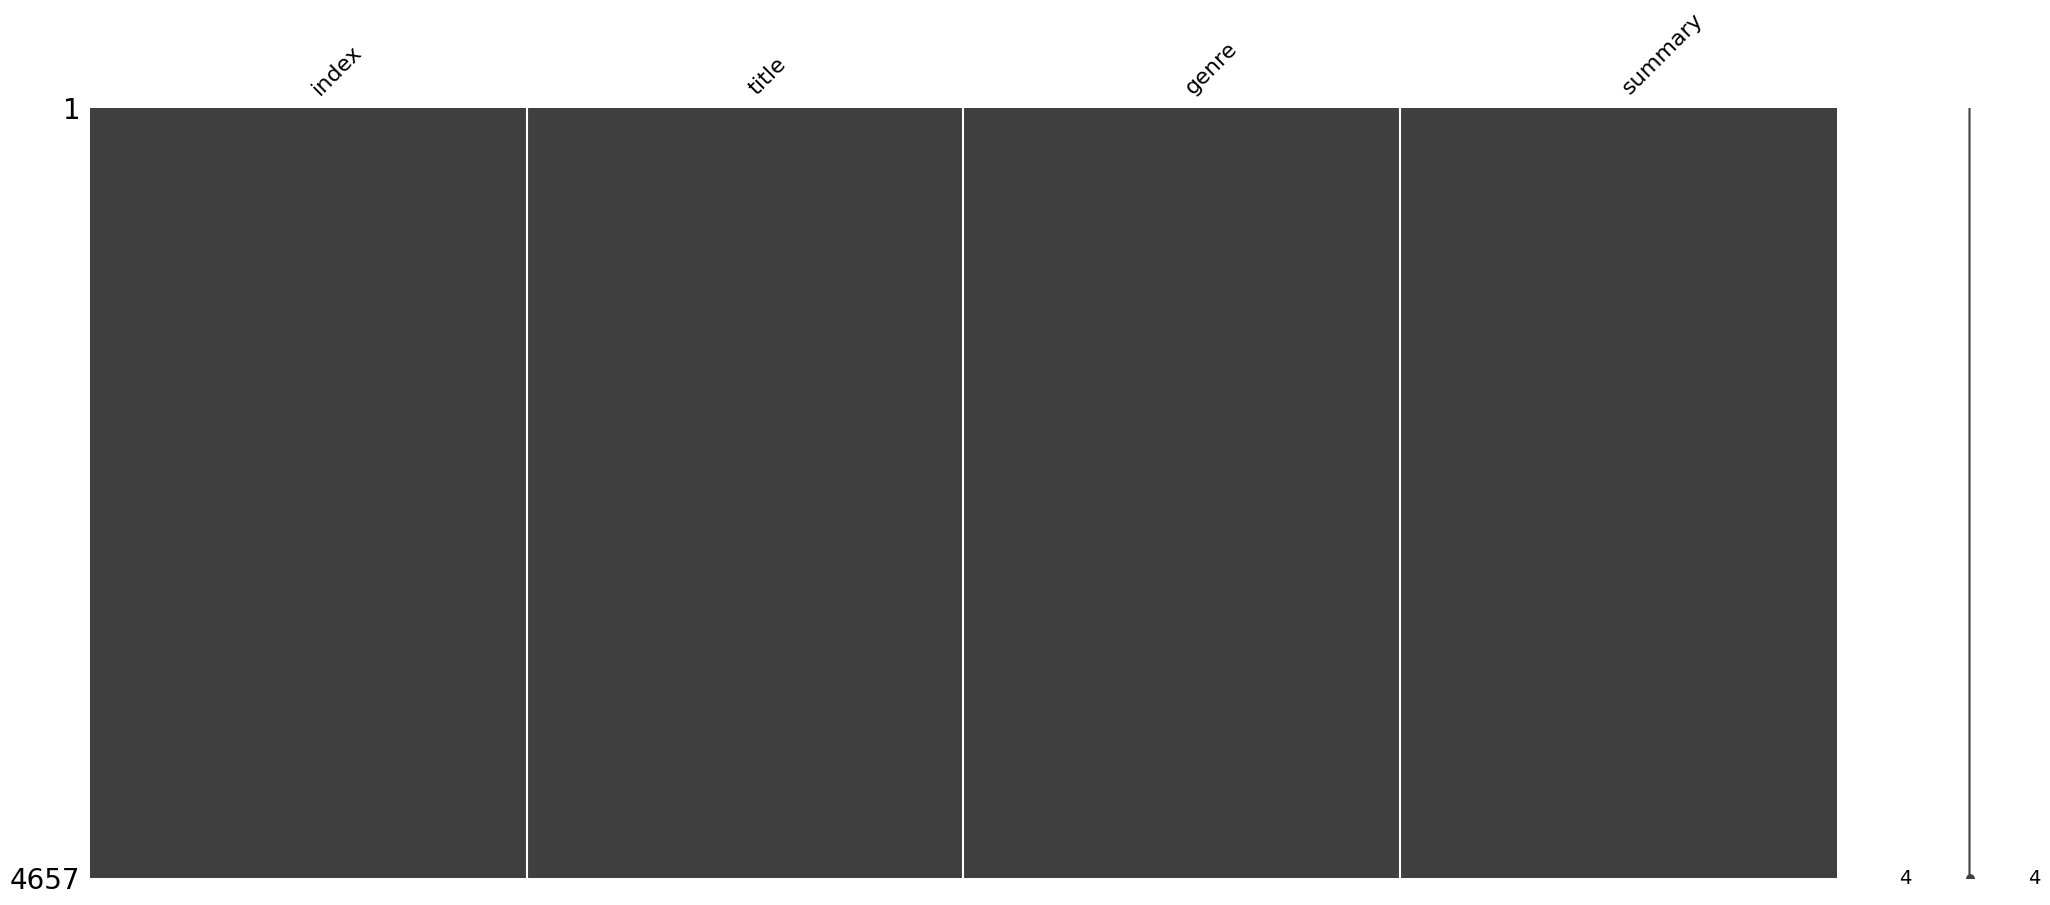

In [88]:
msno.matrix(data)

<a id="section33"></a>
<div style="font-size:15px; font-family:verdana;"><h3 style="font-family:verdana;">Data Cleaning:</h3>
    <p style="font-size:15px; font-family:verdana; line-height: 1.7em">We have no missing values in the data. We drop the <code>Index</code> column as it does not help describe the data in any way.</p>

In [89]:
data.drop('index',inplace = True,axis = 1)
data.head()

title    genre  \
0          Drowned Wednesday  fantasy   
1              The Lost Hero  fantasy   
2  The Eyes of the Overworld  fantasy   
3            Magic's Promise  fantasy   
4             Taran Wanderer  fantasy   

                                             summary  
0   Drowned Wednesday is the first Trustee among ...  
1   As the book opens, Jason awakens on a school ...  
2   Cugel is easily persuaded by the merchant Fia...  
3   The book opens with Herald-Mage Vanyel return...  
4   Taran and Gurgi have returned to Caer Dallben...

<p style="font-size:15px; font-family:verdana; line-height: 1.7em">Removing all stopwords, html tags and other unecessary things which may cause problem while modelling. Using SnowBall Stemmer, for stemming purpose.</p>

In [90]:
#cleaning unecessary text from the string 
Stopwords = set(stopwords.words('english'))

def clean(text):
    text = text.lower() #Converting to lowerCase
    # text = re.sub('[%s]' % re.escape(string.punctuation), ' ',text) #removing punctuation
    
    text_tokens = word_tokenize(text) #removing stopwords
    tw = [word for word in text_tokens if not word in Stopwords]
    text = (" ").join(tw)
    
    splt = text.split(' ')
    output = [x for x in splt if len(x) > 3] #removing words with length<=3
    text = (" ").join(output)
    
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text) #removing single character 
    text = re.sub('<.*?>+',' ',text) #removing HTML Tags
    text = re.sub('\n', ' ',text) #removal of new line characters
    text = re.sub(r'\s+', ' ',text) #removal of multiple spaces
    return text

In [91]:
data['summary'] = data['summary'].map(clean)
data['title'] = data['title'].map(clean)
data

title    genre  \
0             drowned wednesday  fantasy   
1                     lost hero  fantasy   
2                eyes overworld  fantasy   
3                 magic promise  fantasy   
4                taran wanderer  fantasy   
...                         ...      ...   
4652                    hounded  fantasy   
4653  charlie chocolate factory  fantasy   
4654                     rising  fantasy   
4655                  frostbite  fantasy   
4656                   radiance  fantasy   

                                                summary  
0     drowned wednesday first trustee among morrow d...  
1     book opens jason awakens school unable remembe...  
2     cugel easily persuaded merchant fianosther att...  
3     book opens herald-mage vanyel returning countr...  
4     taran gurgi returned caer dallben following ev...  
...                                                 ...  
4652  atticus sullivan last druids lives peacefully ...  
4653  charlie bucket wonderful adventure begins find...  
4654  live dream children born free says like land f...  
4655  rose loves dimitri dimitri might love tasha ma...  
4656  prince value brishen khaskem prince lived cont...  

[4657 rows x 3 columns]

<a id="section34"></a>
<div style="font-family:verdana;"><h3 style="font-family:verdana;">⭐Important Observations :</h3>
    <div class="alert alert-block alert-info">
* <i> There are total of <code>3</code> columns and <code>4657</code> rows in data.</i><br>
* <i> Data contains no missing value.</i><br>
* <i> We drop <code>Index</code> feature as it is of no use.</i><br>
        * <i> There are total of <code>10</code> genres.</i><br>
    </div>
    </div>

<a id="section4"></a>
# Exploratory Data Analysis:

In [92]:
data['genre'].value_counts()

genre
thriller      1023
fantasy        876
science        647
history        600
horror         600
crime          500
romance        111
psychology     100
sports         100
travel         100
Name: count, dtype: int64

<a id="section41"></a>
<div style="font-family:verdana;"><h3 style="font-family:verdana">Count Histogram for each Label :</h3>

In [93]:
genre_df = pd.DataFrame({'genre':['thriller','fantasy','science','history','horror','crime','romance',
                                'psychology','sports','travel'],'count':[1023,876,647,600,600,500,111,
                                                                        100,100,100]})
fig = px.histogram(genre_df,x = 'genre',y = 'count',color = 'genre')
fig.show()

<a id="section42"></a>
<div style="font-family:verdana;"><h3 style="font-family:verdana">WordCloud Analysis :</h3>

In [94]:
from wordcloud import WordCloud

def print_wordCloud(genre,summary):
    print(genre)
    wordcloud = WordCloud(width = 400, height = 400, 
                background_color ='white', 
                min_font_size = 10).generate(summary)
    plt.figure(figsize = (7, 7), facecolor = 'white', edgecolor='blue') 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()
def make_string(genre):
    s = ""
    for row_index,row in data.iterrows():
        if(row['genre'] == genre):
            s+=(row['summary']+' ')
    return s
    

thriller


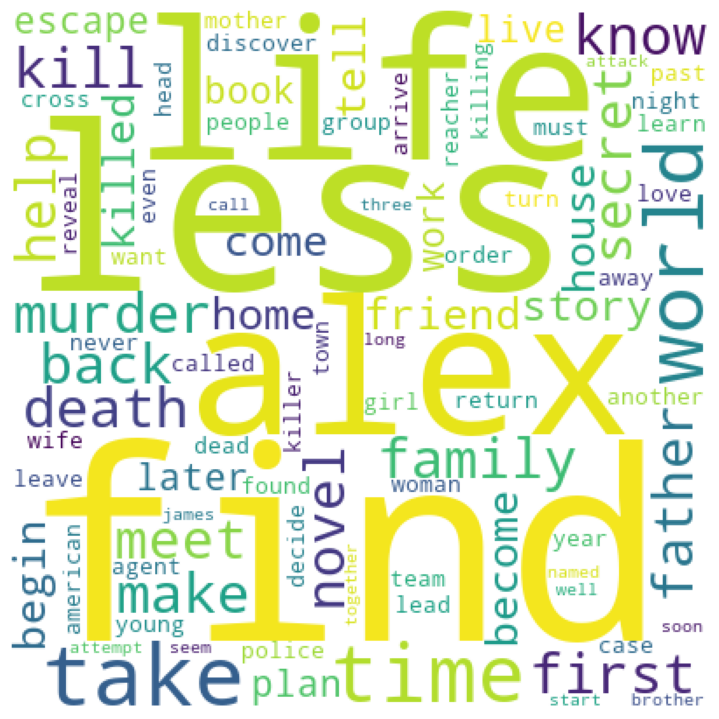

fantasy


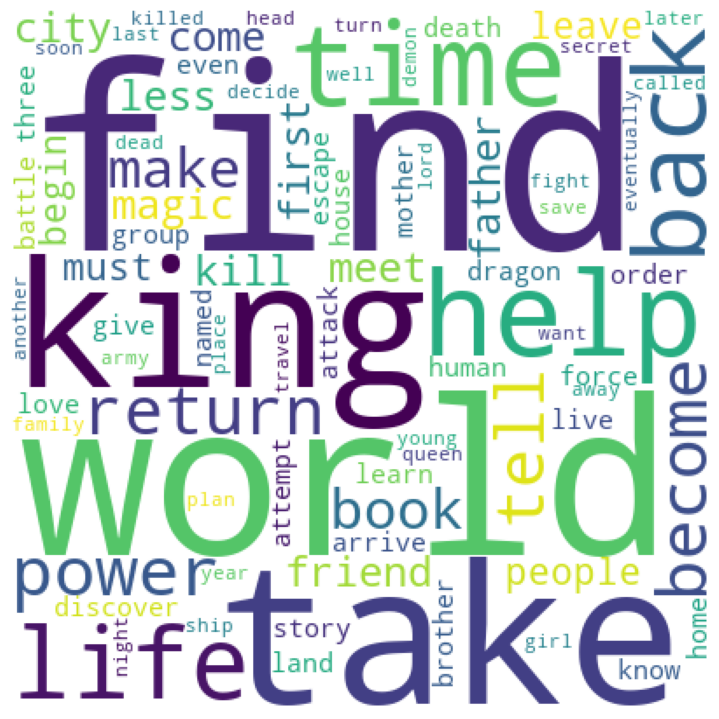

science


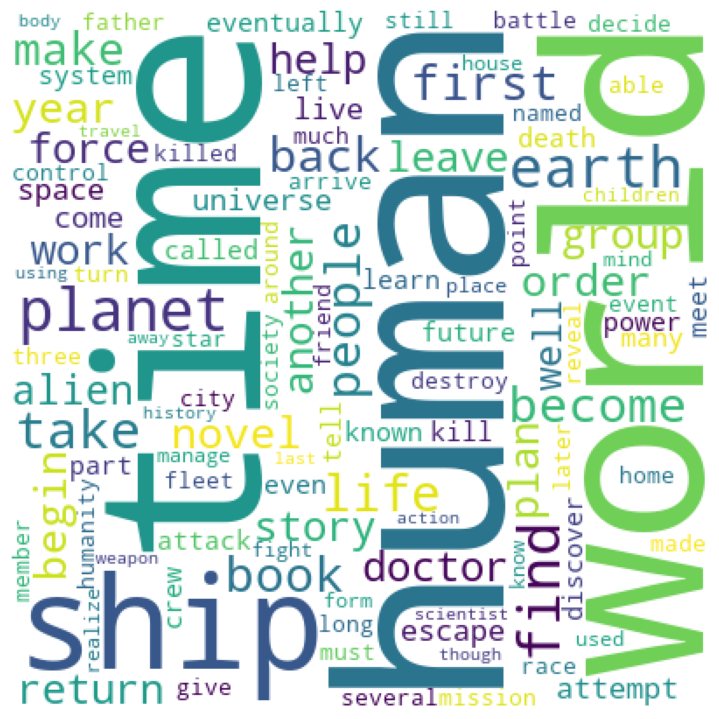

history


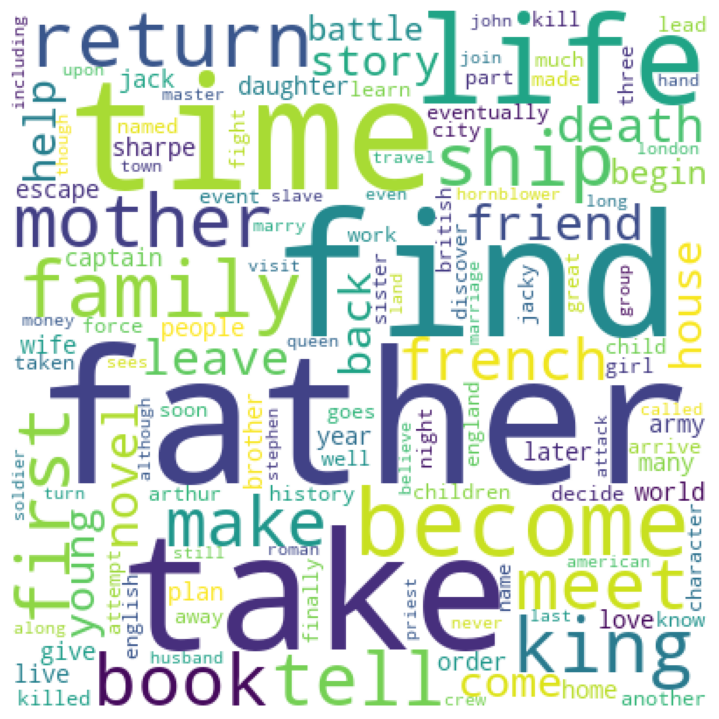

horror


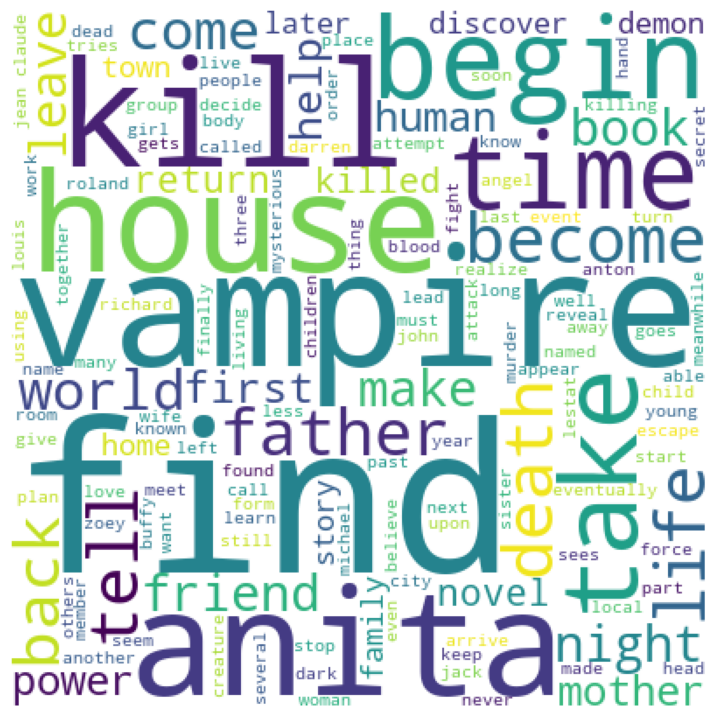

crime


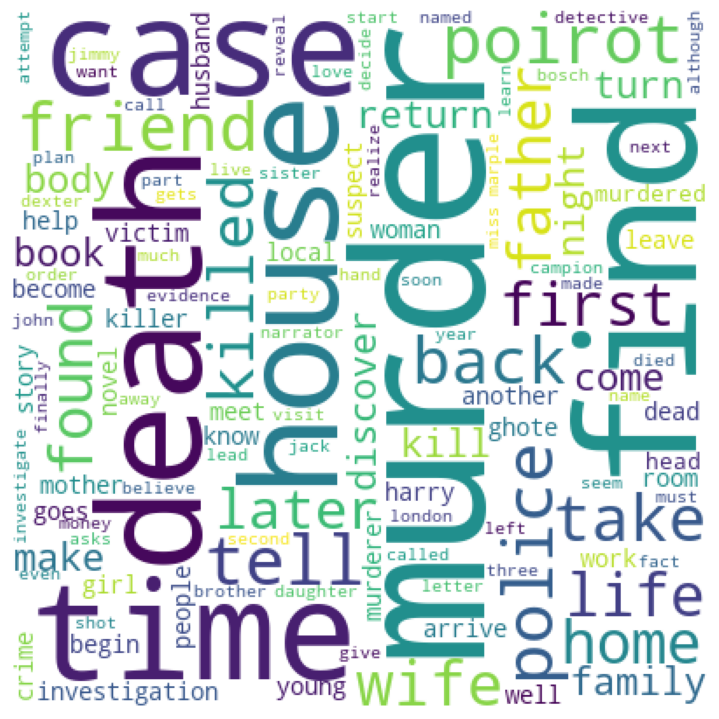

romance


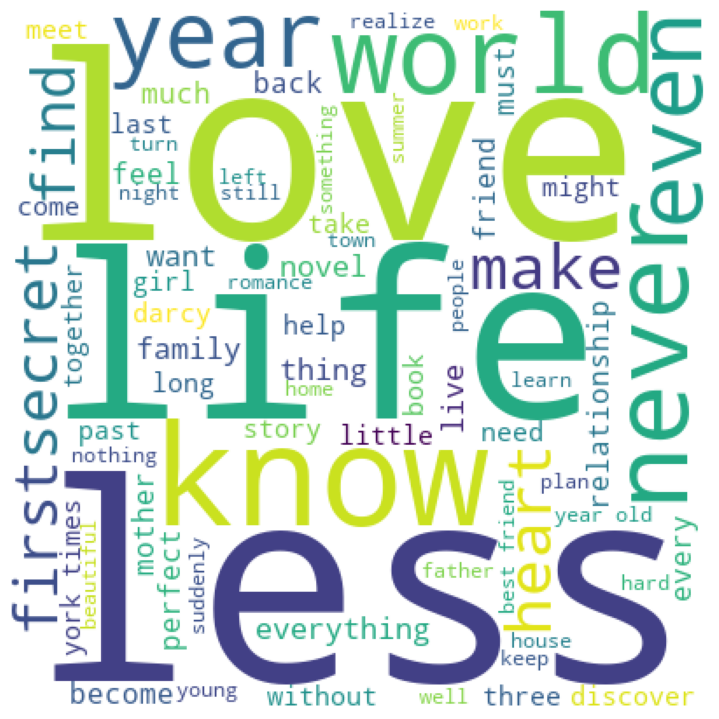

psychology


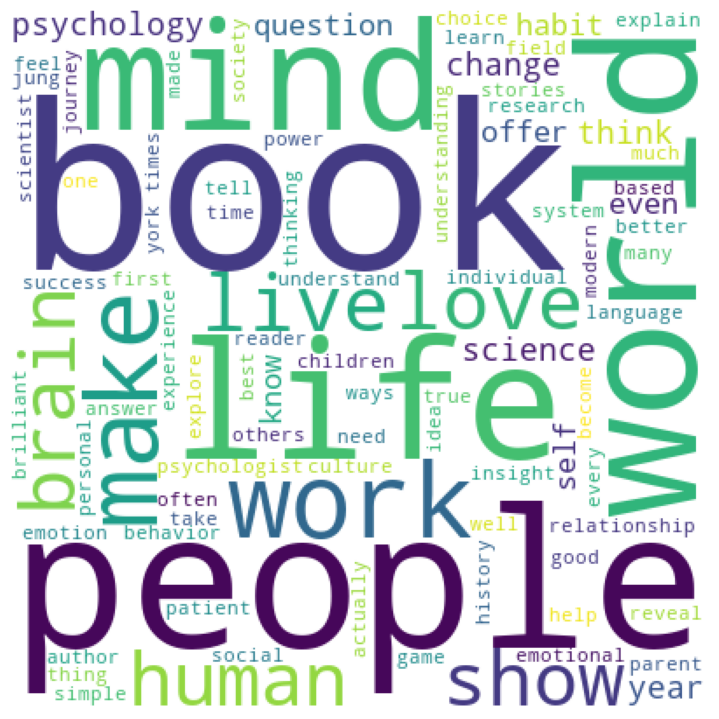

sports


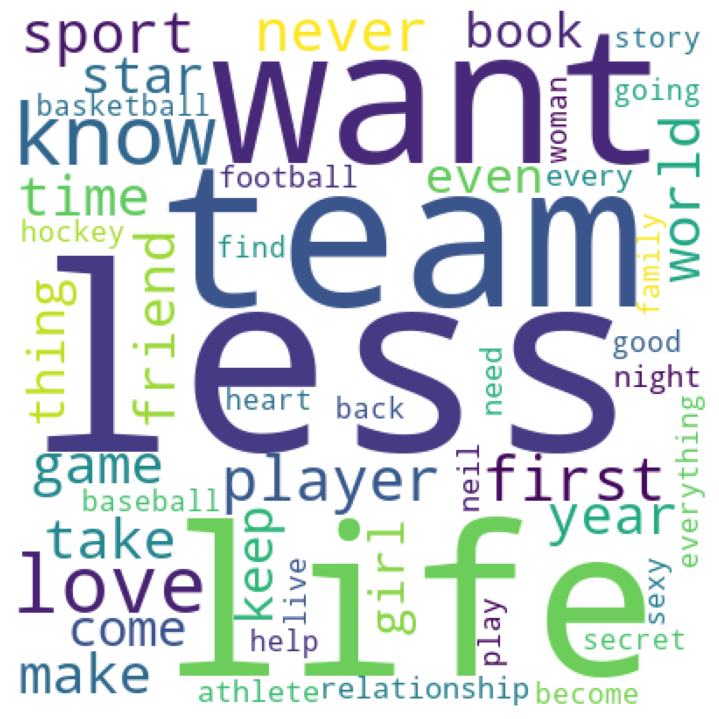

travel


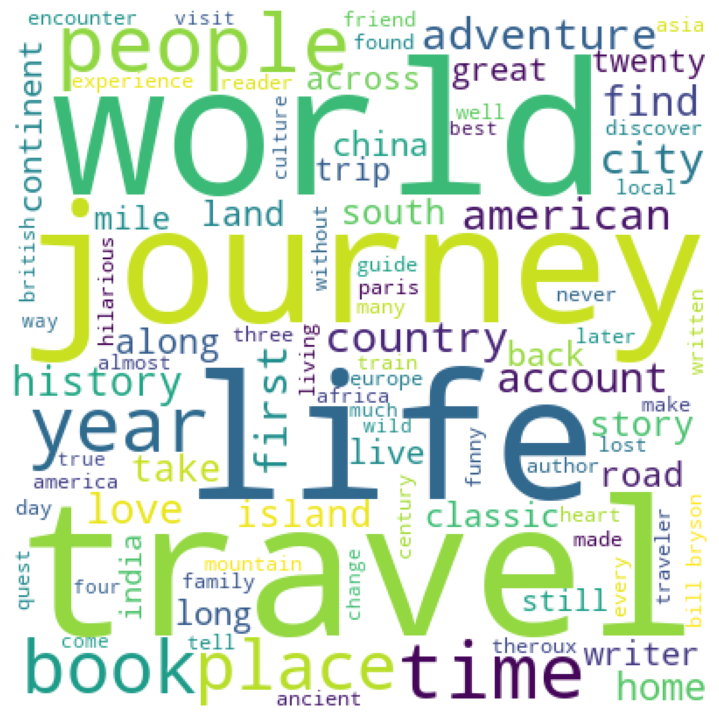

In [95]:
genre = ['thriller','fantasy','science','history','horror','crime','romance',
                                'psychology','sports','travel']
for Genre in genre:
    summary = make_string(Genre)
    print_wordCloud(Genre,summary)

<a id="section5"></a>
# Modelling :

<a id="section51"></a>
<div style="font-size:15px; font-family:verdana;"><h3 style="font-family:verdana;">Data Pre-Processing:</h3>

In [96]:
def data_preprocessing(text):
    tokens = word_tokenize(text) #Tokenization
    tokens = [WordNetLemmatizer().lemmatize(word) for word in tokens] #Lemmetization
    tokens = [SnowballStemmer(language = 'english').stem(word) for word in tokens] #Stemming
    return " ".join(tokens)

In [97]:
data['summary'] = data['summary'].apply(data_preprocessing)
data['title'] = data['title'].apply(data_preprocessing)
data

title    genre  \
0           drown wednesday  fantasy   
1                 lost hero  fantasy   
2             eye overworld  fantasy   
3              magic promis  fantasy   
4              taran wander  fantasy   
...                     ...      ...   
4652                  hound  fantasy   
4653  charli chocol factori  fantasy   
4654                   rise  fantasy   
4655               frostbit  fantasy   
4656                radianc  fantasy   

                                                summary  
0     drown wednesday first truste among morrow day ...  
1     book open jason awaken school unabl rememb any...  
2     cugel easili persuad merchant fianosth attempt...  
3     book open herald-mag vanyel return countri val...  
4     taran gurgi return caer dallben follow event t...  
...                                                 ...  
4652  atticus sullivan last druid life peac arizona ...  
4653  charli bucket wonder adventur begin find willi...  
4654  live dream child born free say like land fathe...  
4655  rose love dimitri dimitri might love tasha mas...  
4656  princ valu brishen khaskem princ live content ...  

[4657 rows x 3 columns]

In [98]:

#Converting all the categorical features of 'genre' to numerical

labelencoder = LabelEncoder()
data['genre_vec'] = labelencoder.fit_transform(data['genre'])
data['genre_vec']

0       1
1       1
2       1
3       1
4       1
       ..
4652    1
4653    1
4654    1
4655    1
4656    1
Name: genre_vec, Length: 4657, dtype: int64

In [99]:
labelencoder.inverse_transform(data['genre_vec'])


array(['fantasy', 'fantasy', 'fantasy', ..., 'fantasy', 'fantasy',
       'fantasy'], dtype=object)

In [101]:
cv = CountVectorizer()
X = cv.fit_transform(data['summary'])
y = data['genre_vec']


In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

models = [BernoulliNB(),MultinomialNB(),SGDClassifier(),LogisticRegression(),RandomForestClassifier(),GradientBoostingClassifier(),
         AdaBoostClassifier(),SVC(),DummyClassifier(),ExtraTreeClassifier(),KNeighborsClassifier()]

<a id="section52"></a>
<div style="font-size:15px; font-family:verdana;"><h3 style="font-family:verdana;">Modelling Using <a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html">OneVsRestClassifier</a>:</h3>

In [24]:
# Name = []
# Accuracy = []
# Precision = []
# F1_Score = []
# Recall = []
# Time_Taken = []
# for model in models:
#     name = type(model).__name__
#     Name.append(name)
#     model = OneVsRestClassifier(model)
#     begin = time.time()
#     model.fit(X_train,y_train)
#     prediction = model.predict(X_test)
#     end = time.time()
#     Accuracy.append(accuracy_score(prediction,y_test))
#     Precision.append(precision_score(prediction,y_test,average = 'macro'))
#     Recall.append(recall_score(prediction,y_test,average = 'macro'))
#     F1_Score.append(f1_score(prediction,y_test,average = 'macro'))
#     Time_Taken.append(end-begin)
#     print(name + ' Successfully Trained')

In [25]:
# Dict = {'Name':Name,'Accuracy':Accuracy,'Precision_score':Precision,'Recall_score':Recall,
#         'F1_score':F1_Score,'Time Taken':Time_Taken}
# model_df = pd.DataFrame(Dict)
# model_df

<a id="section53"></a>
<div style="font-size:15px; font-family:verdana;"><h3 style="font-family:verdana;">Modelling Without Using <a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html">OneVsRest Classifier</a>:</h3>

In [26]:
# Name = []
# Accuracy = []
# Precision = []
# F1_Score = []
# Recall = []
# Time_Taken = []
# for model in models:
#     name = type(model).__name__
#     Name.append(name)
#     begin = time.time()
#     model.fit(X_train,y_train)
#     prediction = model.predict(X_test)
#     end = time.time()
#     Accuracy.append(accuracy_score(prediction,y_test))
#     Precision.append(precision_score(prediction,y_test,average = 'macro'))
#     Recall.append(recall_score(prediction,y_test,average = 'macro'))
#     F1_Score.append(f1_score(prediction,y_test,average = 'macro'))
#     Time_Taken.append(end-begin)
#     print(name + ' Successfully Trained')

In [27]:
# Dict = {'Name':Name,'Accuracy':Accuracy,'Precision_score':Precision,'Recall_score':Precision,
#         'F1_score':F1_Score,'Time Taken':Time_Taken}
# model_df = pd.DataFrame(Dict)
# model_df

<a id="section54"></a>
<div style="font-family:verdana;"><h3 style="font-family:verdana;">Accuracy and Time-Taken Plots :</h3>

In [28]:
# model_df.sort_values(by = 'Accuracy',ascending = False,inplace = True)
# fig = px.line(model_df, x="Name", y="Accuracy", title='Accuracy VS Model')
# fig.show()

In [29]:
# model_df.sort_values(by = 'Time Taken',ascending = False,inplace = True)
# fig = px.line(model_df, x="Name", y="Time Taken", title='Time Taken VS Model')
# fig.show()

<a id="section55"></a>
<div style="font-family:verdana;"><h3 style="font-family:verdana;">Final Observations :</h3>
    <div class="alert alert-block alert-warning">
   <p style="font-size:15px; font-family:verdana; line-height: 1.7em">1. The most common words occuring for each <code>Genre</code> are:<br>
        * <i> <code>Thriller</code> ---> <code>Life</code>,<code>Find</code>,<code>Less</code>.</i><br>
        * <i> <code>Fantasy</code> ---><code>Take</code> <code>Find</code>,<code>World</code>,<code>King</code>.</i><br>
        * <i> <code>Science</code> ---> <code>World</code>,<code>Time</code>,<code>Human</code>.</i><br>
        * <i> <code>History</code> ---> <code>Take</code>,<code>Father</code>,<code>Become</code>.</i><br>
        * <i> <code>Horror</code> ---> <code>Kill</code>,<code>Find</code>,<code>Vampire</code>.</i><br>
        * <i> <code>Crime</code> ---> <code>Murder</code>,<code>Death</code>.</i><br>
        * <i> <code>Romance</code> ---> <code>Life</code>,<code>Love</code>,<code>Less</code>.</i><br>
        * <i> <code>Psychology</code> ---> <code>Life</code>,<code>Book</code>,<code>People</code>.</i><br>
        * <i> <code>Sports</code> ---> <code>Life</code>,<code>Team</code>,<code>Less</code>.</i><br>
        * <i> <code>Travel</code> ---> <code>Life</code>,<code>World</code>,<code>Travel</code>,<code>Journey</code>.</i></p><br>
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">2. <code>Multinomial Naive Bayes</code> model works best for this datasetand also the time taken by <code>MultinomialNB</code> is significantly less.</p><br></div></div>


## predict genre from own books 

In [30]:
MultinomialNB()

MultinomialNB()

In [60]:
# Name = []
# Accuracy = []
# Precision = []
# F1_Score = []
# Recall = []
# Time_Taken = []

model = MultinomialNB()
begin = time.time()
model.fit(X_train,y_train)
prediction = model.predict(X_test)
# end = time.time()
# Accuracy.append(accuracy_score(prediction,y_test))
# Precision.append(precision_score(prediction,y_test,average = 'macro'))
# Recall.append(recall_score(prediction,y_test,average = 'macro'))
# F1_Score.append(f1_score(prediction,y_test,average = 'macro'))
# Time_Taken.append(end-begin)
# print(name + ' Successfully Trained')

In [61]:
import pickle

filename = "model.pickle"

# save model
pickle.dump(model, open(filename, "wb"))

# load model
loaded_model = pickle.load(open(filename, "rb"))

# you can use loaded model to compute predictions
y_predicted = loaded_model.predict(X)

In [62]:
mybooks = pd.read_pickle('../assets/my_books.pkl')
mybooks = mybooks.query('Description.notna()')

In [63]:
def clean(text):
    try:
        text = text.lower() #Converting to lowerCase
        # text = re.sub('[%s]' % re.escape(string.punctuation), ' ',text) #removing punctuation
        
        text_tokens = word_tokenize(text) #removing stopwords
        tw = [word for word in text_tokens if not word in Stopwords]
        text = (" ").join(tw)
        
        splt = text.split(' ')
        output = [x for x in splt if len(x) > 3] #removing words with length<=3
        text = (" ").join(output)
        
        text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text) #removing single character 
        text = re.sub('<.*?>+',' ',text) #removing HTML Tags
        text = re.sub('\n', ' ',text) #removal of new line characters
        text = re.sub(r'\s+', ' ',text) #removal of multiple spaces
        return text
    except: 
        print(text)

In [64]:
def data_preprocessing(text):
    tokens = word_tokenize(text) #Tokenization
    tokens = [WordNetLemmatizer().lemmatize(word) for word in tokens] #Lemmetization
    tokens = [SnowballStemmer(language = 'english').stem(word) for word in tokens] #Stemming
    return " ".join(tokens)

In [65]:
mybooks['Description_cleaned'] = mybooks['Description'].apply(clean)

# data preprocessing 
mybooks['Description'] = mybooks['Description'].apply(data_preprocessing)
mybooks['Description']

0      japanes fairi tale - enchant , enigmat stori o...
1      ' a sensual feast of a novel , written with el...
2      a new york time , usa today , and washington p...
3      * the sunday time number one bestsel * * over ...
4      the addict no.1 bestsel that everyon is talk a...
                             ...                        
359    the key to rebecca is a grip thriller set dure...
360    winner of the pulitz prize , a new york time b...
361    one of the most influenti book of the twentiet...
362    in this deepli stir novel , acclaim author cri...
363    mr jone of manor farm is so lazi and drunken t...
Name: Description, Length: 332, dtype: object

In [66]:
mybooks['Description_cleaned']

0      japanese fairy tales enchanting enigmatic stor...
1      sensual feast novel written elegance beauty ch...
2      york times today washington post bestseller 20...
3      sunday times number bestseller half million co...
4      addictive no.1 bestseller everyone talking don...
                             ...                        
359    rebecca gripping thriller second world number ...
360    winner pulitzer prize york times book review b...
361    influential books twentieth century gets graph...
362    deeply stirring novel acclaimed author cristin...
363    jones manor farm lazy drunken forgets feed liv...
Name: Description_cleaned, Length: 332, dtype: object

In [67]:
test = pd.concat([mybooks['Description'],data['summary']])


In [78]:
#Converting all the categorical features of 'genre' to numerical
nyX = cv.transform(mybooks['Description'])

In [79]:
nyX

<332x39582 sparse matrix of type '<class 'numpy.int64'>'
	with 39137 stored elements in Compressed Sparse Row format>

In [70]:
X_train

<3725x39582 sparse matrix of type '<class 'numpy.int64'>'
	with 477384 stored elements in Compressed Sparse Row format>

In [ ]:
data['summary']

0       drown wednesday first truste among morrow day ...
1       book open jason awaken school unabl rememb any...
2       cugel easili persuad merchant fianosth attempt...
3       book open herald-mag vanyel return countri val...
4       taran gurgi return caer dallben follow event t...
                              ...                        
4652    atticus sullivan last druid life peac arizona ...
4653    charli bucket wonder adventur begin find willi...
4654    live dream child born free say like land fathe...
4655    rose love dimitri dimitri might love tasha mas...
4656    princ valu brishen khaskem princ live content ...
Name: summary, Length: 4657, dtype: object

In [75]:
nyX

<332x39582 sparse matrix of type '<class 'numpy.int64'>'
	with 39137 stored elements in Compressed Sparse Row format>

In [74]:
X_train

<3725x39582 sparse matrix of type '<class 'numpy.int64'>'
	with 477384 stored elements in Compressed Sparse Row format>

In [80]:
# you can use loaded model to compute predictions
genre = loaded_model.predict(nyX)

In [81]:
genre

array([1, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 6, 7, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 1, 8, 8, 1, 8, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 1, 8, 8, 1, 8, 8, 8, 8, 8, 8,
       8, 1, 8, 8, 8, 8, 8, 1, 8, 6, 1, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8,
       8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 1,
       8, 8, 8, 8, 6, 8, 8, 8, 8, 1, 8, 2, 8, 8, 8, 2, 8, 5, 7, 8, 8, 8,
       5, 5, 4, 8, 6, 8, 8, 8, 2, 8, 8, 5, 8, 8, 8, 8, 1, 8, 8, 4, 8, 6,
       8, 8, 6, 8, 8, 8, 4, 1, 8, 8, 8, 8, 8, 8, 1, 8, 7, 8, 6, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 6, 8,
       6, 8, 8, 8, 1, 8, 8, 8, 9, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 6, 8, 8, 8, 8, 8, 1, 1, 8, 8, 8, 8, 8,

In [103]:
inv = labelencoder.inverse_transform(genre)
print(inv)


ValueError: y contains previously unseen labels: ['crime' 'fantasy' 'history' 'horror' 'psychology' 'romance' 'science'
 'sports' 'thriller' 'travel']

In [104]:
inv


array([1, 8, 8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 6, 7, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 1, 8, 8, 1, 8, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 1, 8, 8, 1, 8, 8, 8, 8, 8, 8,
       8, 1, 8, 8, 8, 8, 8, 1, 8, 6, 1, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8,
       8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 1,
       8, 8, 8, 8, 6, 8, 8, 8, 8, 1, 8, 2, 8, 8, 8, 2, 8, 5, 7, 8, 8, 8,
       5, 5, 4, 8, 6, 8, 8, 8, 2, 8, 8, 5, 8, 8, 8, 8, 1, 8, 8, 4, 8, 6,
       8, 8, 6, 8, 8, 8, 4, 1, 8, 8, 8, 8, 8, 8, 1, 8, 7, 8, 6, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 6, 8,
       6, 8, 8, 8, 1, 8, 8, 8, 9, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 6, 8, 8, 8, 8, 8, 1, 1, 8, 8, 8, 8, 8,